In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from utils import get_data, ode_func, solve_ode

PATH = './data/'

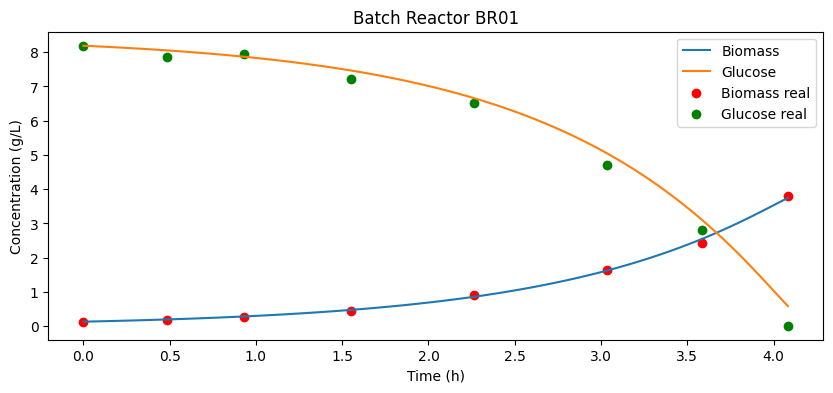

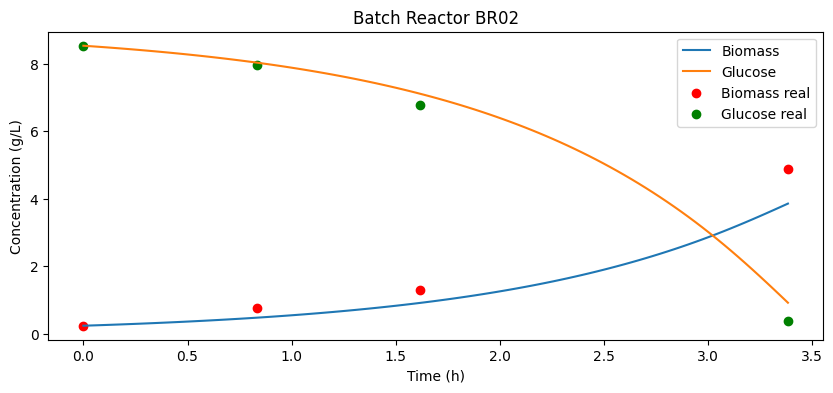

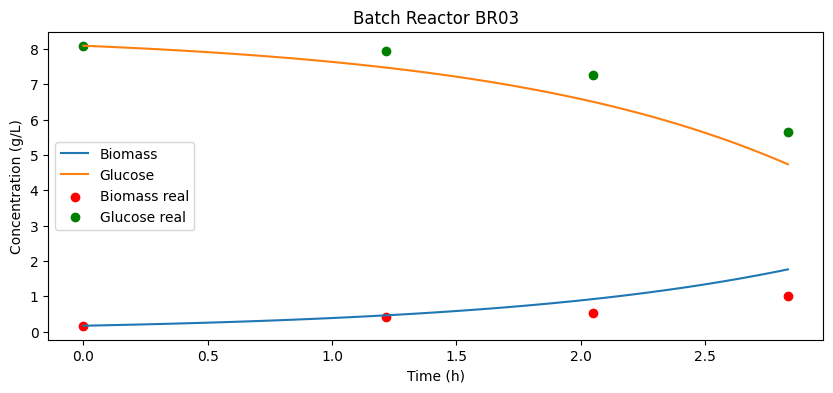

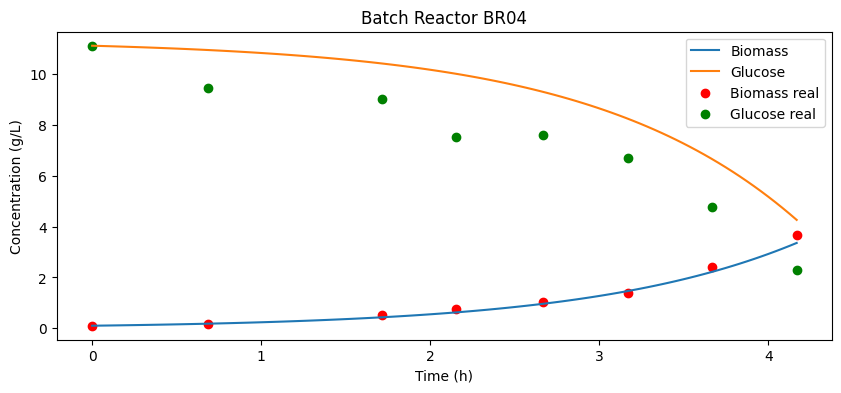

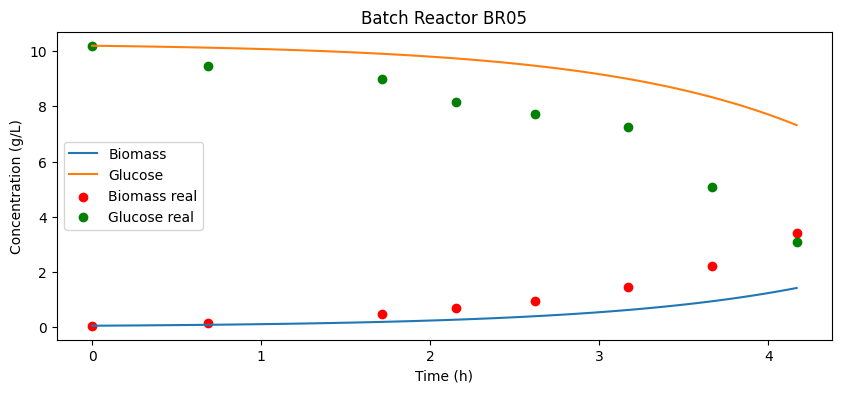

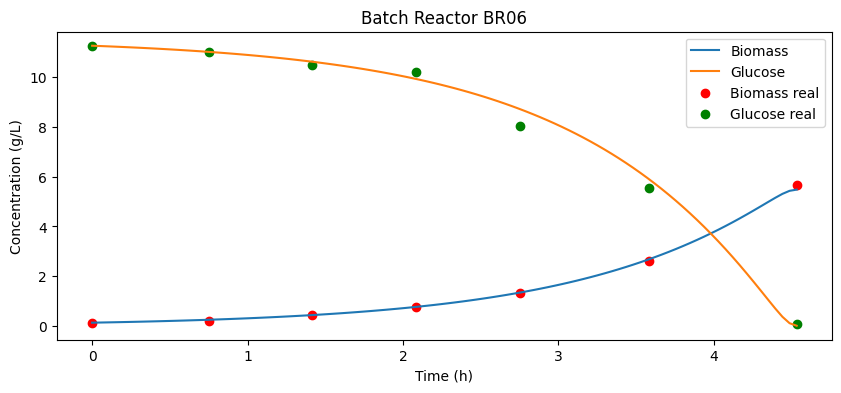

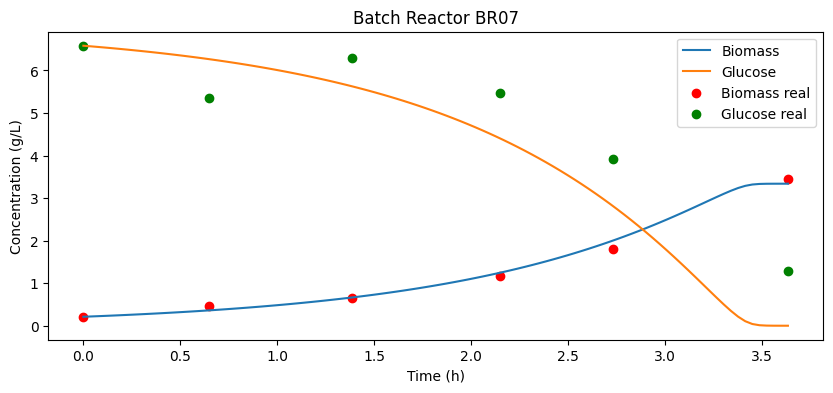

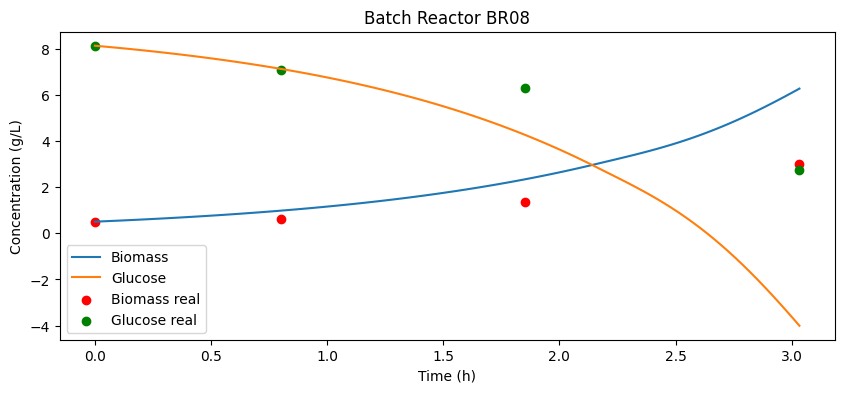

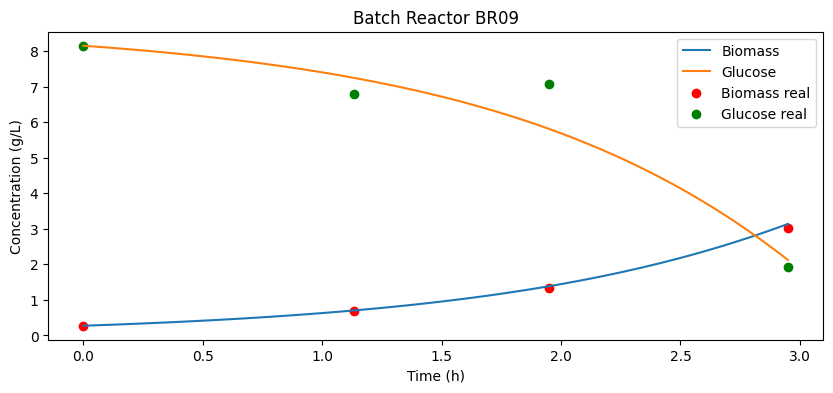

In [17]:
for exp_id in ["BR01", "BR02", "BR03", "BR04", "BR05", "BR06", "BR07", "BR08", "BR09"]:
    df = get_data(exp_id=exp_id, batch=True)
    t_start = df['Time'].values[0]
    t_end = df['Time'].values[-1]   
    y_0 = [df['Biomass'].values[0], df['Glucose'].values[0]]

    sol = solve_ode(mu_max=0.8492, Km=0.1545, Y_XS=0.4752, \
                    t_start=t_start, t_end=t_end, y0=y_0, n_samples=100)

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Glucose')
    plt.scatter(df['Time'], df['Biomass'], label='Biomass real', color='red')
    plt.scatter(df['Time'], df['Glucose'], label='Glucose real', color='green')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.title(f'Batch Reactor {exp_id}')
    plt.legend()
    plt.show()